# KUNet (Kernel U-Net) Demonstration

This notebook demonstrates the capabilities of the KUNet (Kernel U-Net) library, a flexible neural network architecture that combines different kernel types in a U-Net structure. We'll explore basic usage, advanced configurations, and practical applications with time series data.

## Overview

KUNet is designed to be modular and flexible, allowing you to:
- Mix different kernel types (Linear, LSTM, Transformer) in encoder/decoder layers
- Configure U-Net skip connections for better gradient flow
- Handle various input/output dimensions and sequence lengths
- Apply different activation functions and normalization techniques

Let's start by importing the required libraries and setting up our environment.


from src.kunlib import (KUNet, Linear, LSTM, Transformer, 
    Kernel, KernelWrapper, KUNetEncoderDecoder, KUNetEncoder, KUNetDecoder, 
    Projector)
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt

## 1. Basic KUNet Usage

Let's start with a simple example to understand how KUNet works. We'll create a basic model and test it with random input data to verify the dimensions are handled correctly.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
print("\n=== Basic Usage Examples ===")

# 1. Create simple KUNet model
print("1. Create KUNet model:")
model = KUNet(
    input_dim=32,
    input_len=10,
    latent_dim=64,
    output_dim=32,
    output_len=10,
    # Pass parameters directly, no dictionary needed
    unet_skip_concat=False,
    residual=True,
    verbose=False
)
print(model)
# Create random input tensor with appropriate dimensions
batch_size = 32
x = torch.randn(batch_size, model.input_len, model.input_dim).to(device)
print("\n2. Test model with random input:")
print(f"   Input shape: {x.shape}")

# Forward pass
output = model(x)
print(f"   Output shape: {output.shape}")

# Verify output dimensions match expected
expected_shape = (batch_size, model.output_len, model.output_dim)
print(f"   Expected output shape: {expected_shape}")
assert output.shape == expected_shape, f"Output shape {output.shape} doesn't match expected {expected_shape}"

print(f"   Model created successfully, parameter count: {sum(p.numel() for p in model.parameters())}")


=== Basic Usage Examples ===
1. Create KUNet model:
KUNet(
  (model): KUNetEncoderDecoder(
    (encoder): KUNetEncoder(
      (layers): Sequential(
        (0): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=320, out_features=224, bias=True)
              (1): Tanh()
              (2): Dropout(p=0.01, inplace=False)
              (3): Linear(in_features=224, out_features=128, bias=True)
            )
          )
        )
        (1): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=128, out_features=96, bias=True)
              (1): Tanh()
              (2): Dropout(p=0.01, inplace=False)
              (3): Linear(in_features=96, out_features=64, bias=True)
            )
          )
        )
      )
    )
    (decoder): KUNetDecoder(
      (layers): Sequential(
        (0): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
 

## 2. Different Kernel Types Demo

KUNet's power comes from its ability to use different kernel types within the same architecture. Let's explore the three main kernel types:

### 2.1 Linear Kernels
Traditional fully connected layers with configurable activation functions and dropout.

### 2.2 LSTM Kernels  
Recurrent kernels that can capture temporal dependencies in sequence data.

### 2.3 Transformer Kernels
Attention-based kernels that can model complex relationships in the data.


In [16]:

print("\n=== Different Kernel Usage Examples ===")

# 1. Linear Kernel
print("1. Linear Kernel:")
linear_kernel = Linear(
    input_dim=64,
    input_len=10,
    output_dim=64,
    output_len=5,
    # Pass parameters directly
    activation="relu",
    drop_out_p=0.1,
    kernel_hidden_layer=3
)
print(f"   Linear kernel created successfully")
print(linear_kernel)
x = torch.randn(batch_size, linear_kernel.input_len, linear_kernel.input_dim).to(device)
print("\n2. Test linear kernel with random input:")
print(f"   Input shape: {x.shape}")

# Forward pass through linear kernel
output = linear_kernel(x)
print(f"   Output shape: {output.shape}")

# 2. LSTM Kernel
print("\n2. LSTM Kernel:")
lstm_kernel = LSTM(
    input_dim=64,
    input_len=20,
    output_dim=64,
    output_len=10,
    # Pass parameters directly
    drop_out_p=0.2,
    kernel_hidden_layer=2
)
print(f"   LSTM kernel created successfully")
print(lstm_kernel)
x = torch.randn(batch_size, lstm_kernel.input_len, lstm_kernel.input_dim).to(device)
print("\n2. Test LSTM kernel with random input:")
print(f"   Input shape: {x.shape}")

# Forward pass through linear kernel
output = lstm_kernel(x)
print(f"   Output shape: {output.shape}")

# 3. Transformer Kernel
print("\n3. Transformer Kernel:")
transformer_kernel = Transformer(
    input_dim=128,
    input_len=4,
    output_dim=128,
    output_len=1,
    # Pass parameters directly
    num_heads=2,
    drop_out_p=0.1,
    kernel_hidden_layer=2
)
print(f"   Transformer kernel created successfully")
print(transformer_kernel)
x = torch.randn(batch_size, transformer_kernel.input_len, transformer_kernel.input_dim).to(device)
print("\n2. Test Transformer kernel with random input:")
print(f"   Input shape: {x.shape}")

# Forward pass through linear kernel
output = transformer_kernel(x)
print(f"   Output shape: {output.shape}")



=== Different Kernel Usage Examples ===
1. Linear Kernel:
   Linear kernel created successfully
Linear(
  (layers): Sequential(
    (0): Linear(in_features=640, out_features=560, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=560, out_features=480, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=480, out_features=400, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=400, out_features=320, bias=True)
  )
)

2. Test linear kernel with random input:
   Input shape: torch.Size([32, 10, 64])
   Output shape: torch.Size([32, 5, 64])

2. LSTM Kernel:
   LSTM kernel created successfully
LSTM(
  (linear_projection_in): Linear(in_features=1280, out_features=1280, bias=True)
  (linear_projection_out): Linear(in_features=1280, out_features=640, bias=True)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2)
)

2. Test LSTM kernel with random inpu

## 3. Advanced KUNet Configuration

Now let's explore more advanced features of KUNet, including:
- **Multi-layer architectures** with different kernel types
- **U-Net skip connections** for better gradient flow
- **Custom hidden dimensions** and layer configurations
- **Advanced parameters** like normalization and residual connections

We'll create two complex models to demonstrate different kernel combinations.


### 3.1 Mixed Kernel Architecture: Linear + LSTM + Transformer

This model combines three different kernel types in a single architecture, showcasing KUNet's flexibility.

In [31]:

print("\n=== Advanced Usage Examples ===")
# 1. Complex multi-layer network - using default simple settings
print("1. Complex multi-layer network:")
complex_model = KUNet(
    input_dim=128,
    input_len=4,
    n_width=[1],
    n_height=[4, 4],
    latent_dim=128,
    latent_len=1,
    output_dim=128,
    output_len=4,
    hidden_dim_list=[128]*3,
    kernel_list=[Linear, LSTM, Transformer],
    kernel_hidden_layer_list=[1, 2, 2],
    # Advanced parameter settings
    unet_skip=True,
    unet_skip_concat=True,
    inverse_norm=False,
    mean_norm=False,
    chanel_independent=False,
    residual=True,
    activation="leaky_relu",
    num_heads=4,
    verbose=False
).float()
print(f"   Complex model created successfully, parameter count: {sum(p.numel() for p in complex_model.parameters())}")
print(complex_model)
# 2. Test model forward propagation
print("\n2. Test model forward propagation:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fix: Use correct input dimensions (batch_size, input_len, input_dim)
test_input = torch.rand((13, 64, 128)).float().to(device)
print(f"   Input shape: {test_input.shape}")
output = complex_model(test_input)
print(f"   Output shape: {output.shape}")


=== Advanced Usage Examples ===
1. Complex multi-layer network:
   Complex model created successfully, parameter count: 3922496
KUNet(
  (model): KUNetEncoderDecoder(
    (encoder): KUNetEncoder(
      (layers): Sequential(
        (0): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=512, out_features=320, bias=True)
              (1): Dropout(p=0.01, inplace=False)
              (2): Linear(in_features=320, out_features=128, bias=True)
            )
          )
        )
        (1): KernelWrapper(
          (kernel): LSTM(
            (linear_projection_in): Linear(in_features=512, out_features=512, bias=True)
            (linear_projection_out): Linear(in_features=512, out_features=128, bias=True)
            (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.01)
          )
        )
        (2): KernelWrapper(
          (kernel): Transformer(
            (linear_projection_in): Linear(in_features=512

### 3.2 LSTM-Only Architecture

For comparison, let's create a model using only LSTM kernels to see how different kernel configurations affect the model complexity and performance.


In [ ]:
print("2. Complex multi-layer network:")
complex_model = KUNet(
    input_dim=128,
    input_len=4,
    n_width=[1],
    n_height=[4, 4],
    latent_dim=128,
    latent_len=1,
    output_dim=128,
    output_len=4,
    hidden_dim_list=[128]*3,
    kernel_list=[LSTM, LSTM, LSTM],
    kernel_hidden_layer_list=[1, 2, 2],
    # Advanced parameter settings
    unet_skip=True,
    unet_skip_concat=True,
    inverse_norm=False,
    mean_norm=False,
    chanel_independent=False,
    residual=True,
    activation="leaky_relu",
    num_heads=4,
    verbose=False
).float()
print(f"   Complex model created successfully, parameter count: {sum(p.numel() for p in complex_model.parameters())}")

# 2. Test model forward propagation
print("\n2. Test model forward propagation:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fix: Use correct input dimensions (batch_size, input_len, input_dim)
test_input = torch.rand((13, 64, 128)).float().to(device)
print(f"   Input shape: {test_input.shape}")
output = complex_model(test_input)
print(f"   Output shape: {output.shape}")



=== Advanced Usage Examples ===
1. Complex multi-layer network:
   Complex model created successfully, parameter count: 5393280

2. Test model forward propagation:
   Input shape: torch.Size([13, 64, 128])
   Output shape: torch.Size([13, 64, 128])


## 4. Practical Application: Time Series Prediction

Now let's apply KUNet to a real-world scenario - predicting future values in a time series. We'll:

1. **Generate synthetic sine wave data** for training and testing
2. **Create train/test splits** to evaluate model performance
3. **Train KUNet models** with different configurations
4. **Compare performance** between different kernel types
5. **Visualize predictions** to understand model behavior

### 4.1 Data Generation and Preparation

We'll create a synthetic dataset based on sine waves, which provides a good test case for time series prediction models.


In [29]:
# Create a simple time series dataset for testing convergence
import numpy as np
import torch

# Generate synthetic time series data
def generate_sine_wave(T, n_samples, seq_length):
    time = np.linspace(0, 2 * np.pi * T, n_samples) 
    sequences = []
    targets = []
    
    for i in range(n_samples - seq_length * 2):
        # Create sine wave
        t = time[i:i+seq_length]
        sine = np.sin(t)
        sequences.append(sine)
        t = time[i+seq_length:i+seq_length*2]
        sine = np.sin(t)
        targets.append(sine) # Target is same as input for autoencoder
        
    return np.array(sequences), np.array(targets)

# Generate dataset
n_samples = 1000
seq_length = 64
T = 3
X, y = generate_sine_wave(T, n_samples, seq_length)

# Convert to PyTorch tensors and reshape for model
X = torch.FloatTensor(X).unsqueeze(-1).to(device)  # Shape: (n_samples, seq_length, 1)
y = torch.FloatTensor(y).unsqueeze(-1).to(device)  # Shape: (n_samples, seq_length, 1)

print("Training data shape:", X.shape)
print("Target data shape:", y.shape)

# Split into train/test sets
train_size = int(0.5 * n_samples)
X_train = X[:train_size]
y_train = y[:train_size] 
X_test = X[train_size:]
y_test = y[train_size:]

print("\nTrain/test split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Training data shape: torch.Size([872, 64, 1])
Target data shape: torch.Size([872, 64, 1])

Train/test split:
X_train shape: torch.Size([500, 64, 1])
y_train shape: torch.Size([500, 64, 1])
X_test shape: torch.Size([372, 64, 1])
y_test shape: torch.Size([372, 64, 1])


### 4.2 Model Training: Linear + Transformer Architecture

Let's train a KUNet model that combines Linear and Transformer kernels for time series prediction. This combination allows the model to:
- **Linear layers**: Handle basic transformations and feature extraction
- **Transformer layers**: Capture complex temporal dependencies through attention mechanisms

We'll monitor both training and validation loss to ensure the model is learning effectively without overfitting.


In [32]:
# Initialize model
model = KUNet(
    input_dim=1,
    input_len=4, 
    output_dim=1,
    output_len=4,
    hidden_dim_list=[64, 64, 64],
    kernel_list=[Linear, Transformer, Transformer], 
    kernel_hidden_layer_list=[0, 1, 1],
    n_width=[1],
    n_height=[4, 4],
    latent_dim=64,
    latent_len=1,
    verbose=False
).to(device)
print(model)
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
n_epochs = 50
batch_size = 32
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    
    # Train on batches
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        
    train_losses.append(train_loss/len(X_train))
    test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss/len(X_train):.4f}, Test Loss: {test_loss.item():.4f}')



KUNet(
  (model): KUNetEncoderDecoder(
    (encoder): KUNetEncoder(
      (layers): Sequential(
        (0): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=4, out_features=64, bias=True)
            )
          )
        )
        (1): KernelWrapper(
          (kernel): Transformer(
            (linear_projection_in): Linear(in_features=256, out_features=256, bias=True)
            (linear_projection_out): Linear(in_features=256, out_features=64, bias=True)
            (attention): Sequential(
              (0): AttentionBlock(
                (multi_head_attention): MultiHeadAttention(
                  (Wq): Linear(in_features=64, out_features=64, bias=True)
                  (Wk): Linear(in_features=64, out_features=64, bias=True)
                  (Wv): Linear(in_features=64, out_features=64, bias=True)
                  (fc): Linear(in_features=64, out_features=64, bias=True)
                )
                (rel

### 4.3 Results Visualization: Linear + Transformer Model

Let's examine how well our Linear + Transformer model performed:

1. **Training curves**: Show the convergence behavior during training
2. **Prediction examples**: Visualize actual vs predicted sequences on both training and test data

The red dashed line separates the input sequence from the predicted output sequence.

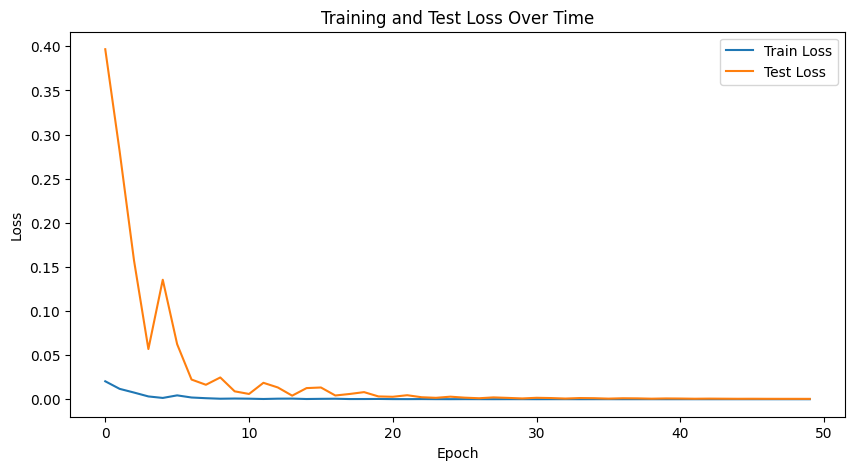

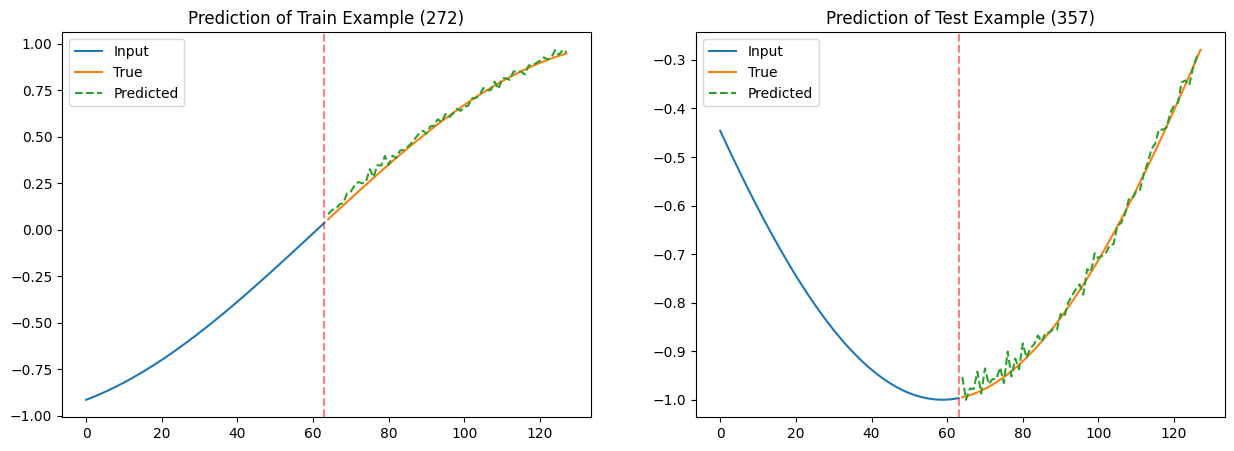

In [23]:

# Plot training curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

# Generate predictions
model.eval()
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# Plot example prediction in first subplot
idx = np.random.randint(0, len(X_train))
with torch.no_grad():
    train_predictions = model(X_train[idx].unsqueeze(0))
input_len = X_train[idx].shape[0]
output_len =y_train[idx].shape[0]
time_steps = np.arange(input_len + output_len)
ax1.plot(time_steps[:input_len], X_train[idx,:,0].cpu().numpy(), label='Input')
ax1.plot(time_steps[input_len:], y_train[idx,:,0].cpu().numpy(), label='True')
ax1.plot(time_steps[input_len:], train_predictions[0, :,0].cpu().numpy(), "--", label='Predicted')
ax1.axvline(x=input_len-1, color='r', linestyle='--', alpha=0.5)
ax1.set_title(f'Prediction of Train Example ({idx})')
ax1.legend()

# Plot example prediction in second subplot
idx = np.random.randint(0, len(X_test))
with torch.no_grad():
    test_predictions = model(X_test[idx].unsqueeze(0))
input_len = X_test[idx].shape[0]
output_len = y_test[idx].shape[0]
time_steps = np.arange(input_len + output_len)
ax2.plot(time_steps[:input_len], X_test[idx,:,0].cpu().numpy(), label='Input')
ax2.plot(time_steps[input_len:], y_test[idx,:,0].cpu().numpy(), label='True')
ax2.plot(time_steps[input_len:], test_predictions[0, :, 0].cpu().numpy(), "--", label='Predicted')
ax2.axvline(x=input_len-1, color='r', linestyle='--', alpha=0.5)
ax2.set_title(f'Prediction of Test Example ({idx})')
ax2.legend()

plt.show()


### 4.4 Model Training: Linear-Only Architecture

For comparison, let's train a model using only Linear kernels. This simpler architecture will help us understand:
- **Performance differences** between kernel types
- **Training behavior** of simpler vs more complex architectures
- **Computational efficiency** trade-offs

Using the same training data and hyperparameters, we can directly compare the results.


In [ ]:
# Initialize model
model = KUNet(
    input_dim=1,
    input_len=4, 
    output_dim=1,
    output_len=4,
    hidden_dim_list=[64, 64, 64],
    kernel_list=[Linear, Linear, Linear], 
    kernel_hidden_layer_list=[0, 1, 1],
    n_width=[1],
    n_height=[4, 4],
    latent_dim=64,
    latent_len=1,
    verbose=False
).to(device)
print(model)
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
n_epochs = 50
batch_size = 32
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    
    # Train on batches
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        
    train_losses.append(train_loss/len(X_train))
    test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss/len(X_train):.4f}, Test Loss: {test_loss.item():.4f}')



KUNet(
  (model): KUNetEncoderDecoder(
    (encoder): KUNetEncoder(
      (layers): Sequential(
        (0): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=4, out_features=64, bias=True)
            )
          )
        )
        (1): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=256, out_features=160, bias=True)
              (1): Tanh()
              (2): Dropout(p=0.01, inplace=False)
              (3): Linear(in_features=160, out_features=64, bias=True)
            )
          )
        )
        (2): KernelWrapper(
          (kernel): Linear(
            (layers): Sequential(
              (0): Linear(in_features=256, out_features=160, bias=True)
              (1): Tanh()
              (2): Dropout(p=0.01, inplace=False)
              (3): Linear(in_features=160, out_features=64, bias=True)
            )
          )
        )
      )
    )
    (

### 4.5 Results Visualization: Linear-Only Model

Let's compare the Linear-only model results with the previous Linear + Transformer model:

1. **Training curves comparison**: Notice differences in convergence speed and final loss values
2. **Prediction quality**: Compare how well each architecture captures the sine wave patterns
3. **Model complexity vs performance**: Evaluate whether the added complexity of Transformer layers provides better results

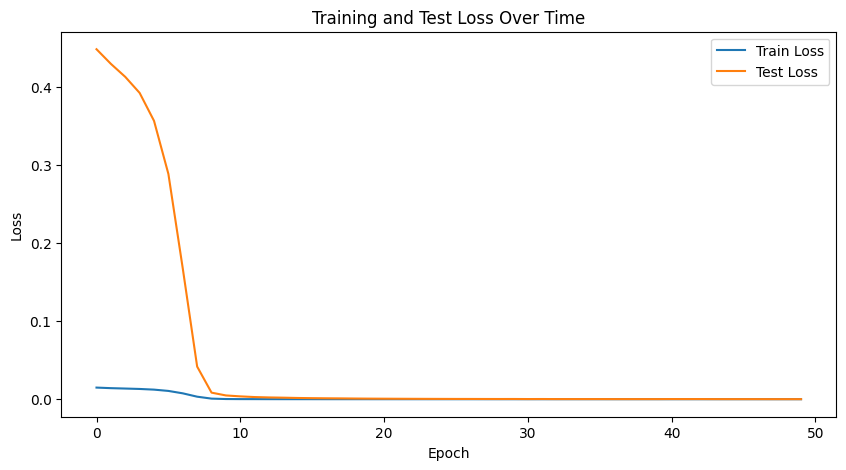

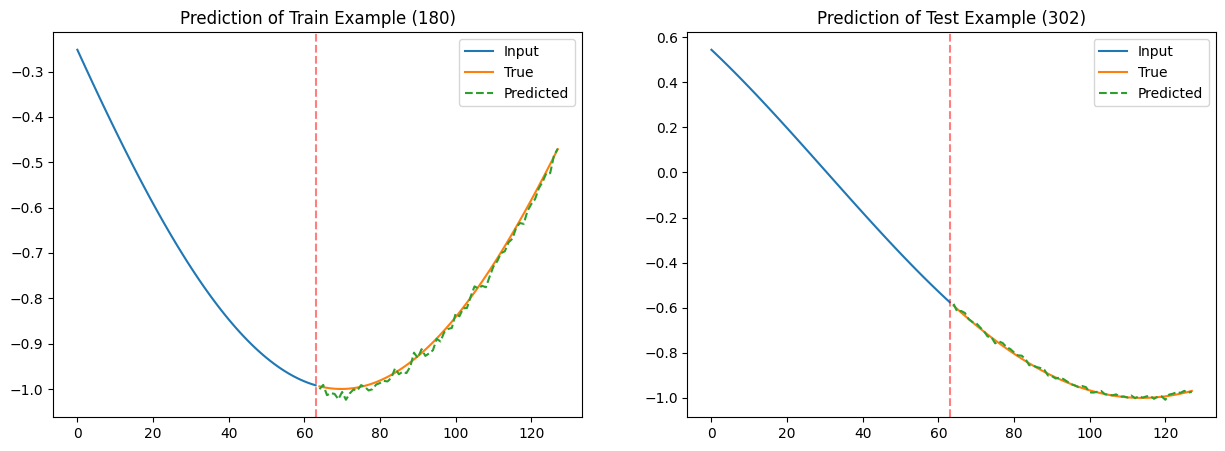

In [ ]:

# Plot training curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

# Generate predictions
model.eval()
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# Plot example prediction in first subplot
idx = np.random.randint(0, len(X_train))
with torch.no_grad():
    train_predictions = model(X_train[idx].unsqueeze(0))
input_len = X_train[idx].shape[0]
output_len =y_train[idx].shape[0]
time_steps = np.arange(input_len + output_len)
ax1.plot(time_steps[:input_len], X_train[idx,:,0].cpu().numpy(), label='Input')
ax1.plot(time_steps[input_len:], y_train[idx,:,0].cpu().numpy(), label='True')
ax1.plot(time_steps[input_len:], train_predictions[0, :,0].cpu().numpy(), "--", label='Predicted')
ax1.axvline(x=input_len-1, color='r', linestyle='--', alpha=0.5)
ax1.set_title(f'Prediction of Train Example ({idx})')
ax1.legend()

# Plot example prediction in second subplot
idx = np.random.randint(0, len(X_test))
with torch.no_grad():
    test_predictions = model(X_test[idx].unsqueeze(0))
input_len = X_test[idx].shape[0]
output_len = y_test[idx].shape[0]
time_steps = np.arange(input_len + output_len)
ax2.plot(time_steps[:input_len], X_test[idx,:,0].cpu().numpy(), label='Input')
ax2.plot(time_steps[input_len:], y_test[idx,:,0].cpu().numpy(), label='True')
ax2.plot(time_steps[input_len:], test_predictions[0, :, 0].cpu().numpy(), "--", label='Predicted')
ax2.axvline(x=input_len-1, color='r', linestyle='--', alpha=0.5)
ax2.set_title(f'Prediction of Test Example ({idx})')
ax2.legend()

plt.show()



## Summary and Conclusions

This notebook demonstrated:

- **Basic KUNet usage** with simple configurations
- **Kernel flexibility** - mixing Linear, LSTM, and Transformer components
- **Advanced configurations** with skip connections and custom parameters  
- **Practical application** to time series prediction
- **Performance comparison** between different kernel architectures

### Key Takeaways:

1. **Modularity**: KUNet allows easy mixing of different kernel types
2. **Flexibility**: Wide range of configuration options for different use cases
3. **U-Net benefits**: Skip connections help with gradient flow in deep architectures
4. **Trade-offs**: More complex kernels (Transformers) may provide better performance but at higher computational cost

The KUNet library provides a powerful and flexible framework for building neural networks that can adapt to various sequence modeling tasks.
